In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from qolmat.diffusion_model  import ImputerDiffusion
from qolmat.model  import TabDDPM, TsDDPM
from diffusion import DDPM

In [2]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

## Load Data

In [4]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [5]:
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:01<00:00, 117.53it/s]


### Preprocess Data

In [6]:
train_df = df_reindexed#.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

## Hyperparameters

In [7]:
# hyperparameters

# diffusion hyperparameters
timesteps = 50
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 30
hidden_dim = 32
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 50
lrate=1e-3

## DDPM

### Models

In [9]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [10]:
from models import AutoEncoder, ResidualBlockTS
model = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = n_feat ,
                    residual_block = ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding = hidden_dim,
)

In [11]:
model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [12]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [13]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

In [14]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

epoch 0


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


Loss: 1.567184335552156, MAE: 1.2484211260452867, Wasserstein Distance: 1.1475209904978456
saved model at ./weights/model_0.pth
epoch 1


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


epoch 2


100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


epoch 3


100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


epoch 4


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Loss: 1.5011234423145652, MAE: 1.220816752873361, Wasserstein Distance: 1.0517713337433907
saved model at ./weights/model_4.pth
epoch 5


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


epoch 6


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


epoch 7


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


epoch 8


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Loss: 1.481372849084437, MAE: 1.2120122853666544, Wasserstein Distance: 1.0364287747367638
saved model at ./weights/model_8.pth
epoch 9


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


epoch 10


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


epoch 11


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


epoch 12


100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


Loss: 1.465566324070096, MAE: 1.2044623102992773, Wasserstein Distance: 1.0185660651331017
saved model at ./weights/model_12.pth
epoch 13


100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


epoch 14


100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


epoch 15


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


epoch 16


100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


Loss: 1.4584639267995954, MAE: 1.201232934370637, Wasserstein Distance: 1.0143442057369154
saved model at ./weights/model_16.pth
epoch 17


100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


epoch 18


100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


epoch 19


100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


epoch 20


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


Loss: 1.453304341994226, MAE: 1.1987746879458427, Wasserstein Distance: 1.0085249218330112
saved model at ./weights/model_20.pth
epoch 21


100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


epoch 22


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


epoch 23


100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


epoch 24


100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Loss: 1.4518160950392485, MAE: 1.1980978194624186, Wasserstein Distance: 1.0093876060915805
saved model at ./weights/model_24.pth
epoch 25


100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


epoch 26


100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


epoch 27


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


epoch 28


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


Loss: 1.4523564726114273, MAE: 1.1980007654055953, Wasserstein Distance: 1.0123511614662046
saved model at ./weights/model_28.pth
epoch 29


100%|██████████| 100/100 [00:08<00:00, 11.38it/s]


epoch 30


100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


epoch 31


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


epoch 32


100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


Loss: 1.4545271201059222, MAE: 1.1991727640852332, Wasserstein Distance: 1.0137837458125427
saved model at ./weights/model_32.pth
epoch 33


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


epoch 34


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


epoch 35


100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


epoch 36


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


Loss: 1.4474966507405043, MAE: 1.1958580752834678, Wasserstein Distance: 1.0068153379161224
saved model at ./weights/model_36.pth
epoch 37


100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


epoch 38


100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


epoch 39


100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


epoch 40


100%|██████████| 100/100 [00:07<00:00, 12.50it/s]


Loss: 1.452012062072754, MAE: 1.1975563960149884, Wasserstein Distance: 1.0142393398973057
saved model at ./weights/model_40.pth
epoch 41


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


epoch 42


100%|██████████| 100/100 [00:08<00:00, 11.65it/s]


epoch 43


100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


epoch 44


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Loss: 1.4474542969837785, MAE: 1.19581404235214, Wasserstein Distance: 1.0077038620016265
saved model at ./weights/model_44.pth
epoch 45


100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


epoch 46


100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


epoch 47


100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


epoch 48


100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Loss: 1.44826521538198, MAE: 1.1959952441975474, Wasserstein Distance: 1.0095198032473551
saved model at ./weights/model_48.pth
epoch 49


100%|██████████| 100/100 [00:08<00:00, 11.71it/s]

Loss: 1.4468089248985052, MAE: 1.195282251574099, Wasserstein Distance: 1.007853029085081
saved model at ./weights/model_49.pth


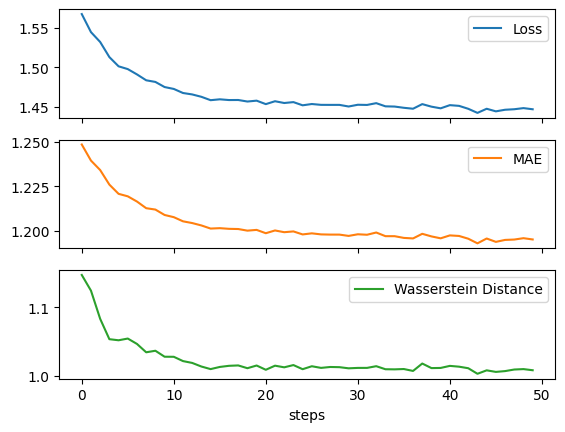

In [15]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [8]:
n_sample = X_train.shape[0] // input_size

In [18]:
gen_samples, _  = ddpm.sample(n_sample = n_sample, window_size = input_size, dim_input = n_feat, save_rate=20)

In [20]:
"""tabddpm = ImputerDiffusion(
    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',
      freq_str = '1B',columnwise=False)"""
#tabddpm.fit(df_reindexed)
#pd.DataFrame(tabddpm.model.summary).plot(subplots=True)
#plt.xlabel('epochs')

"tabddpm = ImputerDiffusion(\n    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',\n      freq_str = '1B',columnwise=False)"

### Evaluation

['BATCH_SIZE', 'LRATE', 'NUM_LAYERS_TRANSFORMER', 'SEQ_LEN']
BATCH_SIZE
['128', '32', '64']
128
Training LDS model...


C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.652238701780637
Epoch [2/10], Loss: 1.1636826942364376
Epoch [3/10], Loss: 0.6990997890631357
Epoch [4/10], Loss: 0.3654440293709437
Epoch [5/10], Loss: 0.2997789954145749
Epoch [6/10], Loss: 0.17415381781756878
Epoch [7/10], Loss: 0.11268467176705599
Epoch [8/10], Loss: 0.10970561858266592
Epoch [9/10], Loss: 0.12976674207796654
Epoch [10/10], Loss: 0.13428316063558063
Training LPS model...
Epoch [1/20], Loss: 1.2550738602876663
Epoch [2/20], Loss: 1.1785703971982002
Epoch [3/20], Loss: 1.126154474914074
Epoch [4/20], Loss: 1.0907760187983513
Epoch [5/20], Loss: 1.0674527361989021
Epoch [6/20], Loss: 1.0551294386386871
Epoch [7/20], Loss: 1.0439114645123482
Epoch [8/20], Loss: 1.0362139195203781
Epoch [9/20], Loss: 1.0314498394727707
Epoch [10/20], Loss: 1.0290578082203865
Epoch [11/20], Loss: 1.0260454788804054
Epoch [12/20], Loss: 1.0151318088173866
Epoch [13/20], Loss: 1.0097409933805466
Epoch [14/20], Loss: 1.0085121765732765
Epoch [15/20], Loss: 0.9980029240

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.5697611669699352
Epoch [2/10], Loss: 1.0442122270663579
Epoch [3/10], Loss: 0.5586672574281693
Epoch [4/10], Loss: 0.2626824025064707
Epoch [5/10], Loss: 0.16531558334827423
Epoch [6/10], Loss: 0.09721263591200113
Epoch [7/10], Loss: 0.06916654668748379
Epoch [8/10], Loss: 0.07295912209277351
Epoch [9/10], Loss: 0.09235501118625204
Epoch [10/10], Loss: 0.08012560708448291
Training LPS model...
Epoch [1/20], Loss: 1.3091349676251411
Epoch [2/20], Loss: 1.2297316864132881
Epoch [3/20], Loss: 1.1804299056529999
Epoch [4/20], Loss: 1.1447401493787766
Epoch [5/20], Loss: 1.1174922585487366
Epoch [6/20], Loss: 1.085175283253193
Epoch [7/20], Loss: 1.078671358525753
Epoch [8/20], Loss: 1.0687544867396355
Epoch [9/20], Loss: 1.0687543079257011
Epoch [10/20], Loss: 1.06477140635252
Epoch [11/20], Loss: 1.0641473978757858
Epoch [12/20], Loss: 1.0570629015564919
Epoch [13/20], Loss: 1.048952892422676
Epoch [14/20], Loss: 1.0534513741731644
Epoch [15/20], Loss: 1.047901533544

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.904104471206665
Epoch [2/10], Loss: 1.4280803551276524
Epoch [3/10], Loss: 0.9846387853225073
Epoch [4/10], Loss: 0.5203623933096727
Epoch [5/10], Loss: 0.22778073139488697
Epoch [6/10], Loss: 0.1581393415108323
Epoch [7/10], Loss: 0.0820555267855525
Epoch [8/10], Loss: 0.06253959098830819
Epoch [9/10], Loss: 0.04517103033140302
Epoch [10/10], Loss: 0.0372119185825189
Training LPS model...
Epoch [1/20], Loss: 1.2871727421879768
Epoch [2/20], Loss: 1.231229193508625
Epoch [3/20], Loss: 1.1788467094302177
Epoch [4/20], Loss: 1.1506305485963821
Epoch [5/20], Loss: 1.1214834451675415
Epoch [6/20], Loss: 1.0964787602424622
Epoch [7/20], Loss: 1.086266241967678
Epoch [8/20], Loss: 1.0826061591506004
Epoch [9/20], Loss: 1.0791003704071045
Epoch [10/20], Loss: 1.0703124925494194
Epoch [11/20], Loss: 1.0702420622110367
Epoch [12/20], Loss: 1.0659559816122055
Epoch [13/20], Loss: 1.0585905089974403
Epoch [14/20], Loss: 1.0472501516342163
Epoch [15/20], Loss: 1.0543926134705

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.551137646039327
Epoch [2/10], Loss: 1.1045814504226048
Epoch [3/10], Loss: 0.6630876138806343
Epoch [4/10], Loss: 0.38593434045712155
Epoch [5/10], Loss: 0.2554372778783242
Epoch [6/10], Loss: 0.14829502875606218
Epoch [7/10], Loss: 0.07717837641636531
Epoch [8/10], Loss: 0.048520488664507866
Epoch [9/10], Loss: 0.037043093548466764
Epoch [10/10], Loss: 0.028049148774395388
Training LPS model...
Epoch [1/20], Loss: 1.2575623840093613
Epoch [2/20], Loss: 1.17421355843544
Epoch [3/20], Loss: 1.1324172616004944
Epoch [4/20], Loss: 1.1036812290549278
Epoch [5/20], Loss: 1.0771513879299164
Epoch [6/20], Loss: 1.0506873652338982
Epoch [7/20], Loss: 1.0346973240375519
Epoch [8/20], Loss: 1.0369543209671974
Epoch [9/20], Loss: 1.0267117768526077
Epoch [10/20], Loss: 1.0300932079553604
Epoch [11/20], Loss: 1.020095594227314
Epoch [12/20], Loss: 1.0153488665819168
Epoch [13/20], Loss: 1.0087560787796974
Epoch [14/20], Loss: 1.0089056342840195
Epoch [15/20], Loss: 1.00294516

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.4570139199495316
Epoch [2/10], Loss: 0.9021715621153513
Epoch [3/10], Loss: 0.4254230285684268
Epoch [4/10], Loss: 0.19518120090166727
Epoch [5/10], Loss: 0.10685297256956498
Epoch [6/10], Loss: 0.127092313952744
Epoch [7/10], Loss: 0.07743172285457452
Epoch [8/10], Loss: 0.06975464709103107
Epoch [9/10], Loss: 0.054637511260807514
Epoch [10/10], Loss: 0.05051446116218964
Training LPS model...
Epoch [1/20], Loss: 1.3084024861454964
Epoch [2/20], Loss: 1.2256339862942696
Epoch [3/20], Loss: 1.1554758995771408
Epoch [4/20], Loss: 1.1143315881490707
Epoch [5/20], Loss: 1.0972083732485771
Epoch [6/20], Loss: 1.0964734181761742
Epoch [7/20], Loss: 1.0929301232099533
Epoch [8/20], Loss: 1.0823411121964455
Epoch [9/20], Loss: 1.082294575870037
Epoch [10/20], Loss: 1.0860244408249855
Epoch [11/20], Loss: 1.0716236531734467
Epoch [12/20], Loss: 1.0766637548804283
Epoch [13/20], Loss: 1.0621415749192238
Epoch [14/20], Loss: 1.0651697739958763
Epoch [15/20], Loss: 1.06504400

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.6654429237047832
Epoch [2/10], Loss: 1.2016655157009761
Epoch [3/10], Loss: 0.7091950351993243
Epoch [4/10], Loss: 0.3148270547389984
Epoch [5/10], Loss: 0.19555513995389143
Epoch [6/10], Loss: 0.12105999048799276
Epoch [7/10], Loss: 0.061812120179335274
Epoch [8/10], Loss: 0.043218997617562614
Epoch [9/10], Loss: 0.03672478208318353
Epoch [10/10], Loss: 0.027943600124369066
Training LPS model...
Epoch [1/20], Loss: 1.535758137702942
Epoch [2/20], Loss: 1.4717615693807602
Epoch [3/20], Loss: 1.4271713644266129
Epoch [4/20], Loss: 1.386495441198349
Epoch [5/20], Loss: 1.3693631142377853
Epoch [6/20], Loss: 1.3314440175890923
Epoch [7/20], Loss: 1.32702074944973
Epoch [8/20], Loss: 1.3232139125466347
Epoch [9/20], Loss: 1.308786392211914
Epoch [10/20], Loss: 1.315324917435646
Epoch [11/20], Loss: 1.3038656562566757
Epoch [12/20], Loss: 1.3005137890577316
Epoch [13/20], Loss: 1.2892414182424545
Epoch [14/20], Loss: 1.2809784635901451
Epoch [15/20], Loss: 1.2711048126

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.6106813500324886
Epoch [2/10], Loss: 1.1003187249104183
Epoch [3/10], Loss: 0.6220493813355764
Epoch [4/10], Loss: 0.25379657683273155
Epoch [5/10], Loss: 0.23362617225696644
Epoch [6/10], Loss: 0.10296707786619663
Epoch [7/10], Loss: 0.07371408492326736
Epoch [8/10], Loss: 0.05986111735304197
Epoch [9/10], Loss: 0.04139036204045018
Epoch [10/10], Loss: 0.03449951019138098
Training LPS model...
Epoch [1/20], Loss: 3.064934641122818
Epoch [2/20], Loss: 2.976567417383194
Epoch [3/20], Loss: 2.9278890192508698
Epoch [4/20], Loss: 2.872918039560318
Epoch [5/20], Loss: 2.8467368483543396
Epoch [6/20], Loss: 2.811635285615921
Epoch [7/20], Loss: 2.791540563106537
Epoch [8/20], Loss: 2.768140345811844
Epoch [9/20], Loss: 2.7580361664295197
Epoch [10/20], Loss: 2.7496999502182007
Epoch [11/20], Loss: 2.726971447467804
Epoch [12/20], Loss: 2.712212413549423
Epoch [13/20], Loss: 2.698936402797699
Epoch [14/20], Loss: 2.6907070875167847
Epoch [15/20], Loss: 2.677564263343811

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.4570640077193577
Epoch [2/10], Loss: 0.8565355514486631
Epoch [3/10], Loss: 0.405299832423528
Epoch [4/10], Loss: 0.1942450236529112
Epoch [5/10], Loss: 0.1463397645081083
Epoch [6/10], Loss: 0.08158166737606128
Epoch [7/10], Loss: 0.251101840287447
Epoch [8/10], Loss: 0.42569004464894533
Epoch [9/10], Loss: 0.24254489038139582
Epoch [10/10], Loss: 0.14435088851799568
Training LPS model...
Epoch [1/20], Loss: 1.2522742599248886
Epoch [2/20], Loss: 1.1740112602710724
Epoch [3/20], Loss: 1.1271923184394836
Epoch [4/20], Loss: 1.0817549750208855
Epoch [5/20], Loss: 1.0566835701465607
Epoch [6/20], Loss: 1.0324883535504341
Epoch [7/20], Loss: 1.0323376432061195
Epoch [8/20], Loss: 1.0136998444795609
Epoch [9/20], Loss: 1.012562595307827
Epoch [10/20], Loss: 1.0047908127307892
Epoch [11/20], Loss: 1.0053095519542694
Epoch [12/20], Loss: 1.0035366863012314
Epoch [13/20], Loss: 0.990857370197773
Epoch [14/20], Loss: 0.9935559034347534
Epoch [15/20], Loss: 0.9974873885512

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.6531113435824711
Epoch [2/10], Loss: 1.177791674931844
Epoch [3/10], Loss: 0.7262324020266533
Epoch [4/10], Loss: 0.3429383995632331
Epoch [5/10], Loss: 0.20537387393414974
Epoch [6/10], Loss: 0.25750445884962875
Epoch [7/10], Loss: 0.1149189779534936
Epoch [8/10], Loss: 0.08227993672092755
Epoch [9/10], Loss: 0.07158123205105464
Epoch [10/10], Loss: 0.04405807719255487
Training LPS model...
Epoch [1/20], Loss: 1.2681964859366417
Epoch [2/20], Loss: 1.184858277440071
Epoch [3/20], Loss: 1.1336421072483063
Epoch [4/20], Loss: 1.0924527198076248
Epoch [5/20], Loss: 1.077456921339035
Epoch [6/20], Loss: 1.063441552221775
Epoch [7/20], Loss: 1.0723672807216644
Epoch [8/20], Loss: 1.0698383077979088
Epoch [9/20], Loss: 1.058825820684433
Epoch [10/20], Loss: 1.0585735142230988
Epoch [11/20], Loss: 1.0577537789940834
Epoch [12/20], Loss: 1.0511018112301826
Epoch [13/20], Loss: 1.045656569302082
Epoch [14/20], Loss: 1.0374071449041367
Epoch [15/20], Loss: 1.03535998612642

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.8024220863978069
Epoch [2/10], Loss: 1.294901783267657
Epoch [3/10], Loss: 0.8542595778902372
Epoch [4/10], Loss: 0.4458326610426108
Epoch [5/10], Loss: 0.22609120483199754
Epoch [6/10], Loss: 0.17811141970256963
Epoch [7/10], Loss: 0.09452370274811983
Epoch [8/10], Loss: 0.060390579203764595
Epoch [9/10], Loss: 0.05141386855393648
Epoch [10/10], Loss: 0.03940056978414456
Training LPS model...
Epoch [1/20], Loss: 1.1137483790516853
Epoch [2/20], Loss: 1.0501936376094818
Epoch [3/20], Loss: 1.0018952935934067
Epoch [4/20], Loss: 0.9595849066972733
Epoch [5/20], Loss: 0.9293784499168396
Epoch [6/20], Loss: 0.9181313589215279
Epoch [7/20], Loss: 0.9029228016734123
Epoch [8/20], Loss: 0.9000308588147163
Epoch [9/20], Loss: 0.8965630233287811
Epoch [10/20], Loss: 0.893336609005928
Epoch [11/20], Loss: 0.8883797451853752
Epoch [12/20], Loss: 0.8816128671169281
Epoch [13/20], Loss: 0.8830758407711983
Epoch [14/20], Loss: 0.8736331090331078
Epoch [15/20], Loss: 0.87686677

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.6022264957427979
Epoch [2/10], Loss: 1.0720958511034648
Epoch [3/10], Loss: 0.6398359077672163
Epoch [4/10], Loss: 0.2204881596068541
Epoch [5/10], Loss: 0.19273401672641435
Epoch [6/10], Loss: 0.13768310317148766
Epoch [7/10], Loss: 0.12381032637010018
Epoch [8/10], Loss: 0.09094092001517613
Epoch [9/10], Loss: 0.09392528080691893
Epoch [10/10], Loss: 0.1934225456789136
Training LPS model...
Epoch [1/20], Loss: 1.019343115389347
Epoch [2/20], Loss: 0.9511622413992882
Epoch [3/20], Loss: 0.8982688337564468
Epoch [4/20], Loss: 0.8687756061553955
Epoch [5/20], Loss: 0.841122530400753
Epoch [6/20], Loss: 0.8267475143074989
Epoch [7/20], Loss: 0.820749543607235
Epoch [8/20], Loss: 0.8151454254984856
Epoch [9/20], Loss: 0.8104136139154434
Epoch [10/20], Loss: 0.8187609165906906
Epoch [11/20], Loss: 0.8073131144046783
Epoch [12/20], Loss: 0.8033512681722641
Epoch [13/20], Loss: 0.7975659444928169
Epoch [14/20], Loss: 0.8034125342965126
Epoch [15/20], Loss: 0.79895840585

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/10], Loss: 0.10305990278720856
Epoch [3/10], Loss: 0.09289627708494663
Epoch [4/10], Loss: 0.08298646099865437
Epoch [5/10], Loss: 0.07121400535106659
Epoch [6/10], Loss: 0.06529451906681061
Epoch [7/10], Loss: 0.05760679766535759
Epoch [8/10], Loss: 0.04575956519693136
Epoch [9/10], Loss: 0.04191107116639614
Epoch [10/10], Loss: 0.03265874180942774
Training LPS model...
Epoch [1/20], Loss: 0.21759919987784493
Epoch [2/20], Loss: 0.21785755289925468
Epoch [3/20], Loss: 0.208245317141215
Epoch [4/20], Loss: 0.20249952872594199
Epoch [5/20], Loss: 0.20097111993365818
Epoch [6/20], Loss: 0.19427180290222168
Epoch [7/20], Loss: 0.1892911261982388
Epoch [8/20], Loss: 0.1905517710579766
Epoch [9/20], Loss: 0.18395082155863443
Epoch [10/20], Loss: 0.17963037888209024
Epoch [11/20], Loss: 0.17966777086257935
Epoch [12/20], Loss: 0.17549383640289307
Epoch [13/20], Loss: 0.1716695229212443
Epoch [14/20], Loss: 0.17437595791286892
Epoch [15/20], Loss: 0.17132796181572807
Epoch [16/20], L

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 1.6935379604498546
Epoch [2/10], Loss: 1.1898201704025269
Epoch [3/10], Loss: 0.7068084478378296
Epoch [4/10], Loss: 0.34964804102977115
Epoch [5/10], Loss: 0.17244761809706688
Epoch [6/10], Loss: 0.1492810845375061
Epoch [7/10], Loss: 0.0880718445405364
Epoch [8/10], Loss: 0.11224873984853427
Epoch [9/10], Loss: 0.07750439923256636
Epoch [10/10], Loss: 0.04886548267677426
Training LPS model...
Epoch [1/20], Loss: 1.2941403537988663
Epoch [2/20], Loss: 1.220537044107914
Epoch [3/20], Loss: 1.1686194315552711
Epoch [4/20], Loss: 1.135301984846592
Epoch [5/20], Loss: 1.1037157028913498
Epoch [6/20], Loss: 1.094625324010849
Epoch [7/20], Loss: 1.0823947489261627
Epoch [8/20], Loss: 1.071059912443161
Epoch [9/20], Loss: 1.0654952228069305
Epoch [10/20], Loss: 1.0638127103447914
Epoch [11/20], Loss: 1.0699802413582802
Epoch [12/20], Loss: 1.0589105784893036
Epoch [13/20], Loss: 1.062867321074009
Epoch [14/20], Loss: 1.0479287654161453
Epoch [15/20], Loss: 1.0481771156191

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/10], Loss: 0.1614932045340538
Epoch [3/10], Loss: 0.13984641432762146
Epoch [4/10], Loss: 0.13300997018814087
Epoch [5/10], Loss: 0.12762849032878876
Epoch [6/10], Loss: 0.12020842358469963
Epoch [7/10], Loss: 0.12502330914139748
Epoch [8/10], Loss: 0.11193174496293068
Epoch [9/10], Loss: 0.100884560495615
Epoch [10/10], Loss: 0.08942194655537605
Training LPS model...
Epoch [1/20], Loss: 0.07680575847625733
Epoch [2/20], Loss: 0.07492462635040283
Epoch [3/20], Loss: 0.07288765430450439
Epoch [4/20], Loss: 0.07106734752655029
Epoch [5/20], Loss: 0.06937819957733155
Epoch [6/20], Loss: 0.0675801134109497
Epoch [7/20], Loss: 0.06578476428985595
Epoch [8/20], Loss: 0.06532535552978516
Epoch [9/20], Loss: 0.06301133632659912
Epoch [10/20], Loss: 0.06238877296447754
Epoch [11/20], Loss: 0.06053744316101074
Epoch [12/20], Loss: 0.060039210319519046
Epoch [13/20], Loss: 0.05882907390594482
Epoch [14/20], Loss: 0.05774016857147217
Epoch [15/20], Loss: 0.05722732543945312
Epoch [16/20],

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/10], Loss: 0.09527073428034782
Epoch [3/10], Loss: 0.08257277775555849
Epoch [4/10], Loss: 0.07063759118318558
Epoch [5/10], Loss: 0.06048018019646406
Epoch [6/10], Loss: 0.04806691315025091
Epoch [7/10], Loss: 0.03678899956867099
Epoch [8/10], Loss: 0.02481830818578601
Epoch [9/10], Loss: 0.018388689728453755
Epoch [10/10], Loss: 0.012597420951351523
Training LPS model...
Epoch [1/20], Loss: 1.5793482065200806
Epoch [2/20], Loss: 1.4985851526260376
Epoch [3/20], Loss: 1.4584601879119874
Epoch [4/20], Loss: 1.4914481878280639
Epoch [5/20], Loss: 1.3469840049743653
Epoch [6/20], Loss: 1.2814727783203126
Epoch [7/20], Loss: 1.2868093013763429
Epoch [8/20], Loss: 1.2649261474609375
Epoch [9/20], Loss: 1.2324973583221435
Epoch [10/20], Loss: 1.256943130493164
Epoch [11/20], Loss: 1.215366792678833
Epoch [12/20], Loss: 1.29532151222229
Epoch [13/20], Loss: 1.1877280712127685
Epoch [14/20], Loss: 1.179163670539856
Epoch [15/20], Loss: 1.206192398071289
Epoch [16/20], Loss: 1.1922175

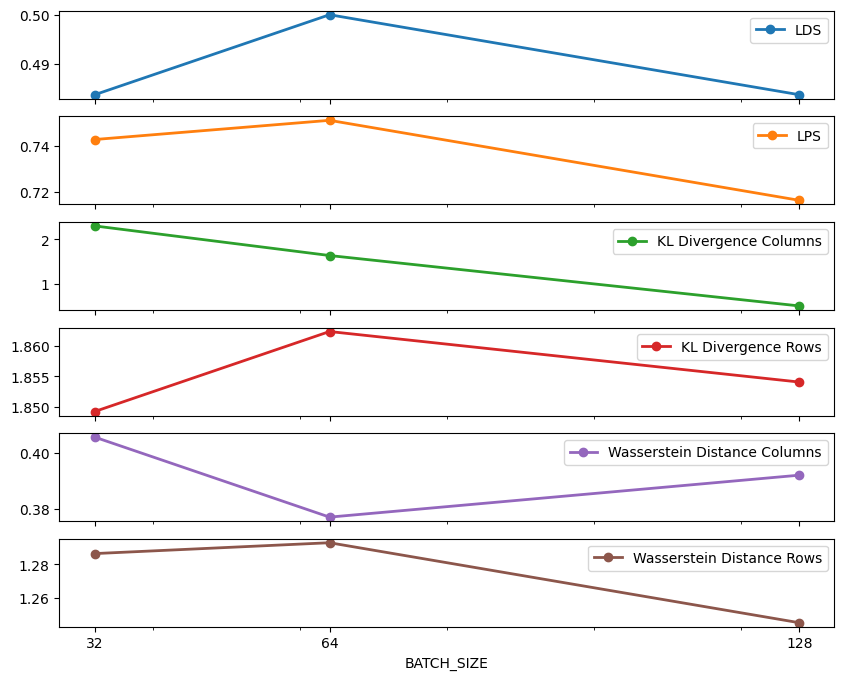

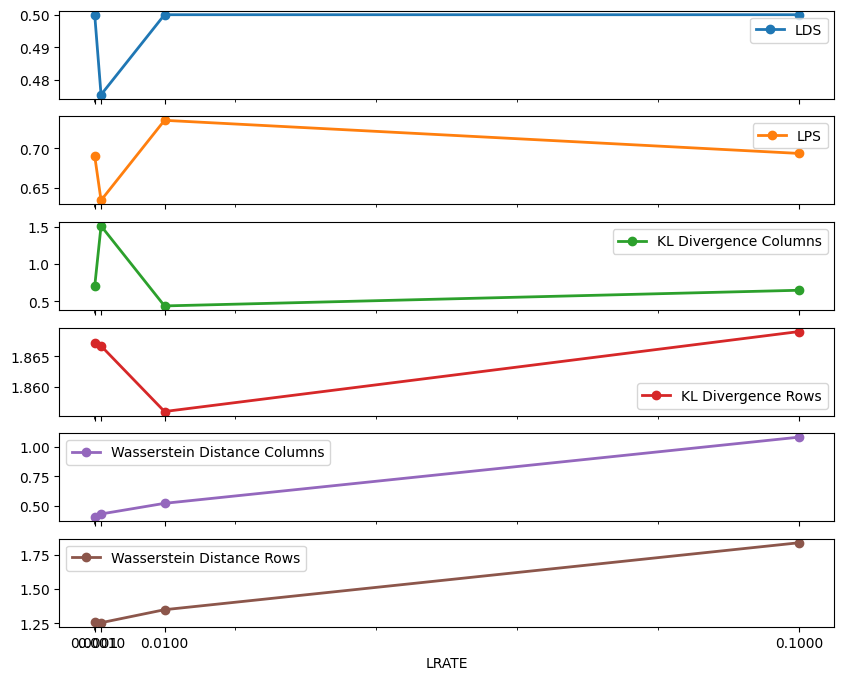

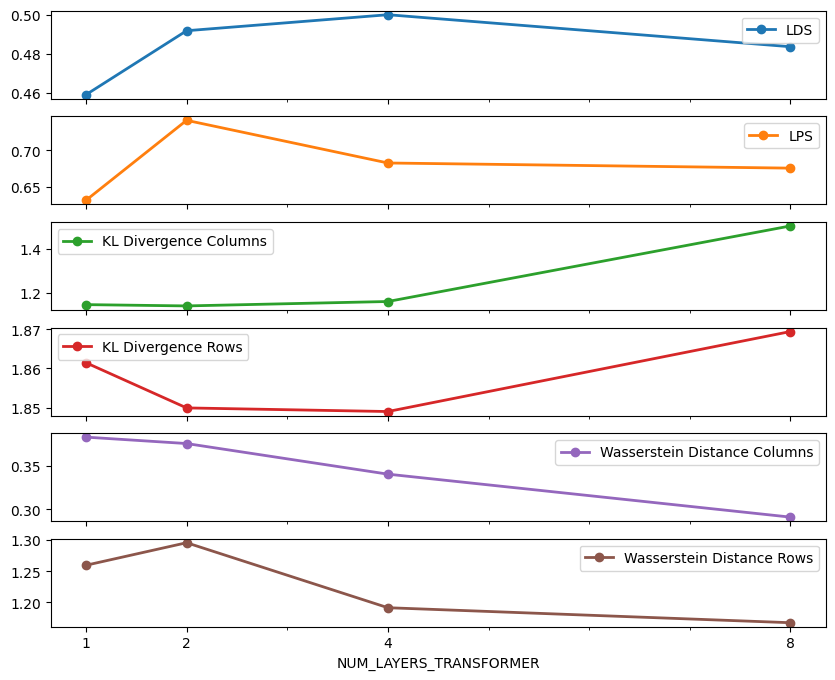

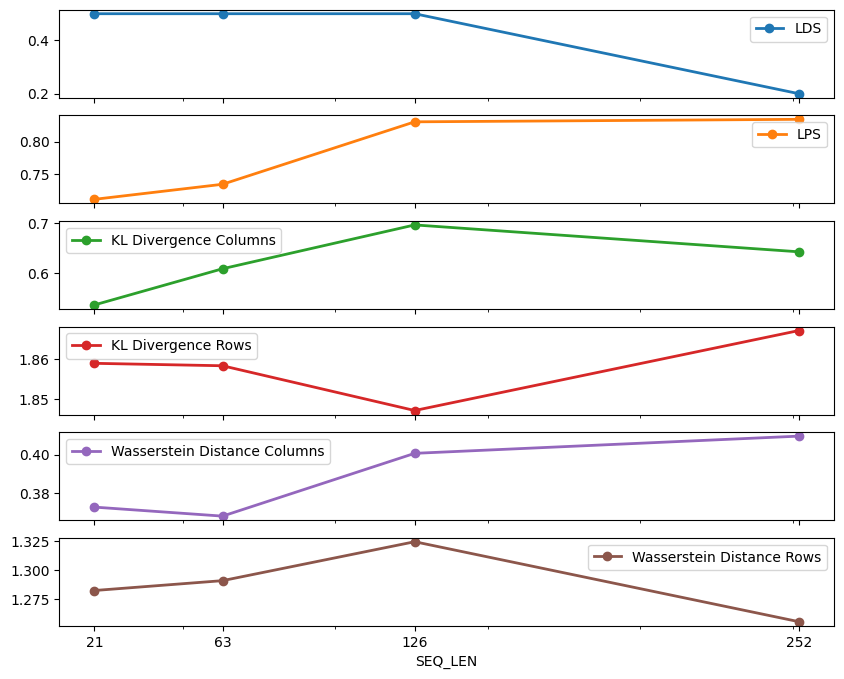

In [119]:
import json
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data
#path_results = os.getcwd() + "\\results\\DDPM\\"
path_results = os.getcwd() + "\\100\\"
parameters = [d for d in os.listdir(path_results) if os.path.isdir(os.path.join(path_results, d))]
print(parameters)
for param in parameters:
    print(param)
    path_parameters = path_results + param
    var = [d for d in os.listdir(path_parameters) if os.path.isdir(os.path.join(path_parameters, d))]
    print(var)
    train_ratio = 0.8
    results = {}
    for v in var:
        print(v)
        config_results = json.load(open(path_parameters + "\\" + v + '\\config.json', 'r'))
        #create  samples from df_orig time series
        seq_len = config_results["SEQ_LEN"]
        n_samples = X_train.shape[0] // seq_len
        samples_orig = np.zeros((n_samples, seq_len, n_feat))
        for i in range(n_samples):
            idx = np.random.randint(0, df_orig.shape[0]-seq_len)
            samples_orig[i] = df_orig.iloc[idx:idx+seq_len].values

        gen_samples = np.load(path_parameters + "\\" + v + '\\samples.npy')[:n_samples]
        eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
        eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
        eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=train_ratio)
        results[v] = eval_results    
    results_df = pd.DataFrame(results).T
    results_df.index = results_df.index.astype(float)
    results_df = results_df.sort_index()
    results_df.index.name = param
    results_df.plot(subplots=True, figsize=(10, 8), linewidth=2, marker='o')
    plt.xticks(results_df.index)
    plt.savefig('.\\plots\\' + param + '_epoch_300_timesteps_100'+'.png')

#### Visualisations

In [31]:
df_orig = df_orig['Ret'].unstack().T

In [34]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

torch.Size([6390, 53])

In [41]:
synth_data = pd.DataFrame(gen_samples[0,:,:].numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [42]:
from plot_results import plot_data

In [43]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [64]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [66]:
true_data = df_orig[start_year_test:]

In [67]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [72]:
kl_col.mean().values[0]

1.097511773567949

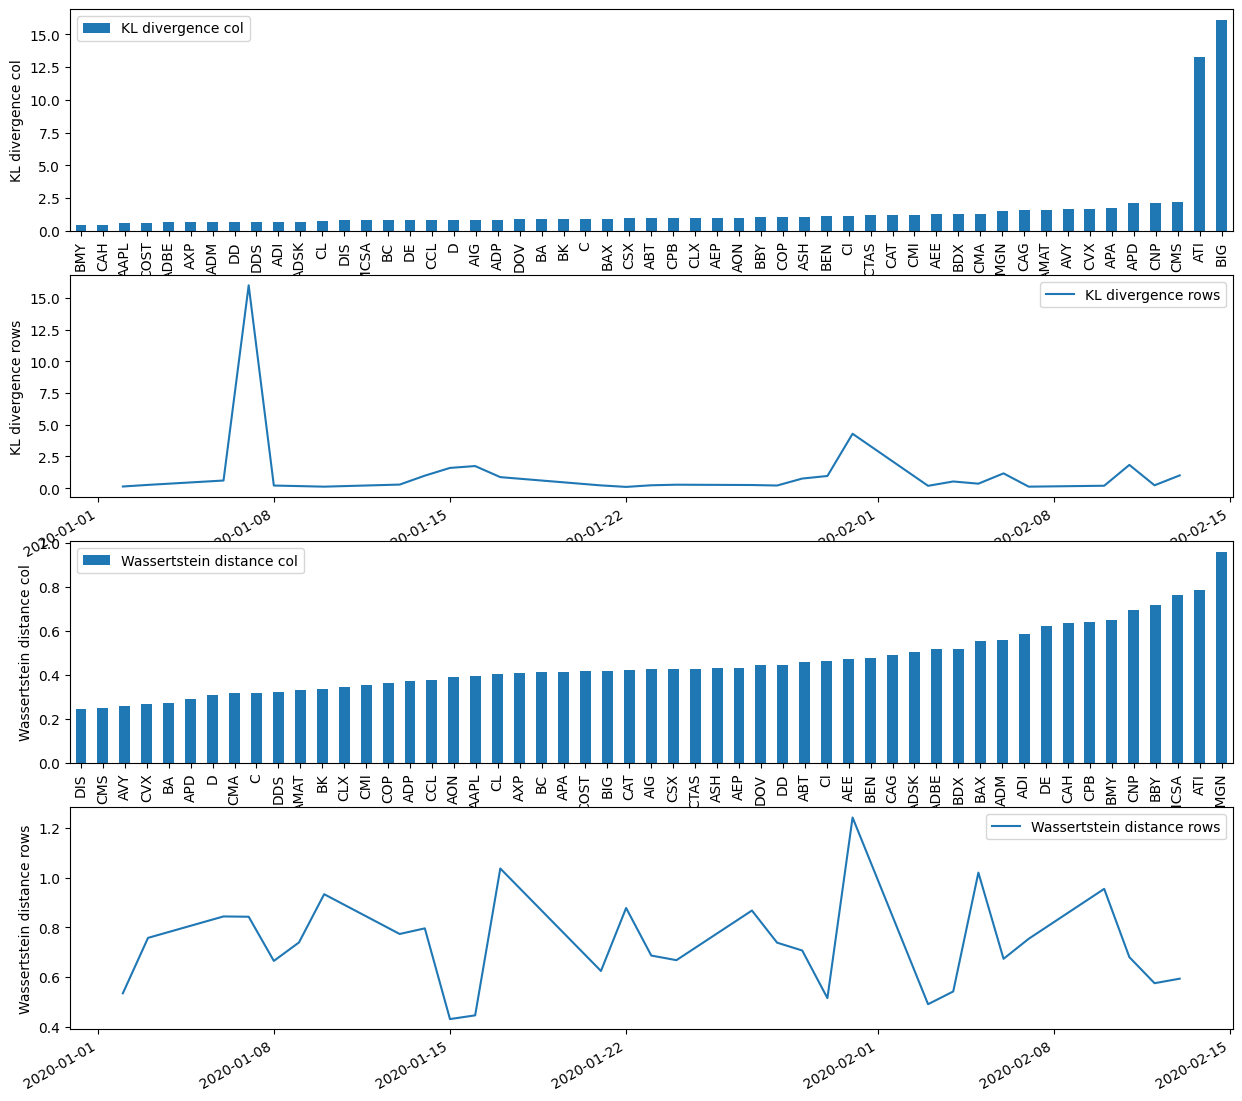

In [ ]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


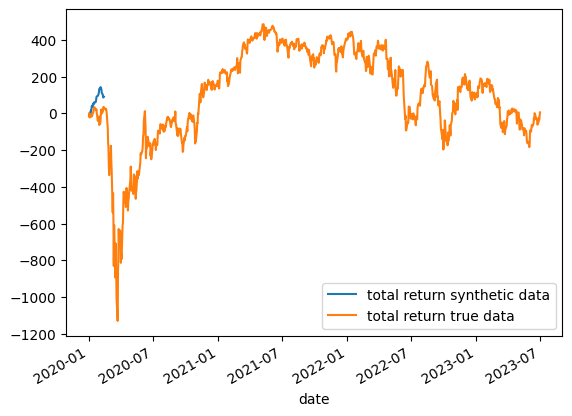

In [ ]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [ ]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synthetic_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



Frobenius Norm: 35.529801727303045
Spectral Norm: 29.30747090917304
Condition Number - True Data: 383.2139665503995
Condition Number - Synthetic Data: 2.0961685590888143e+18


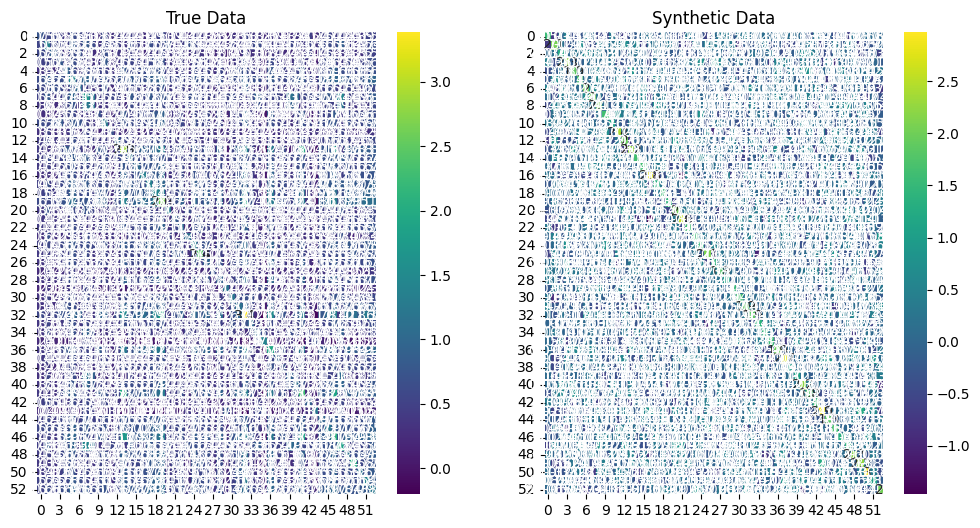

In [ ]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


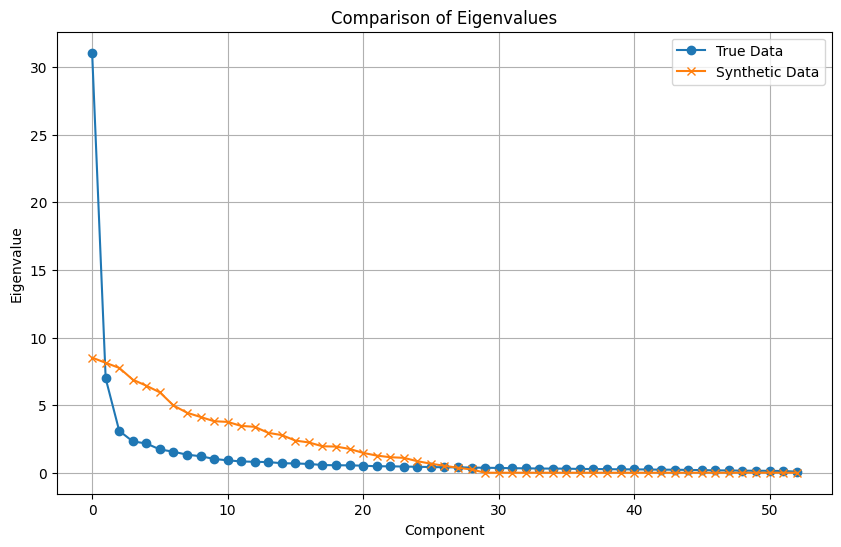

In [ ]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


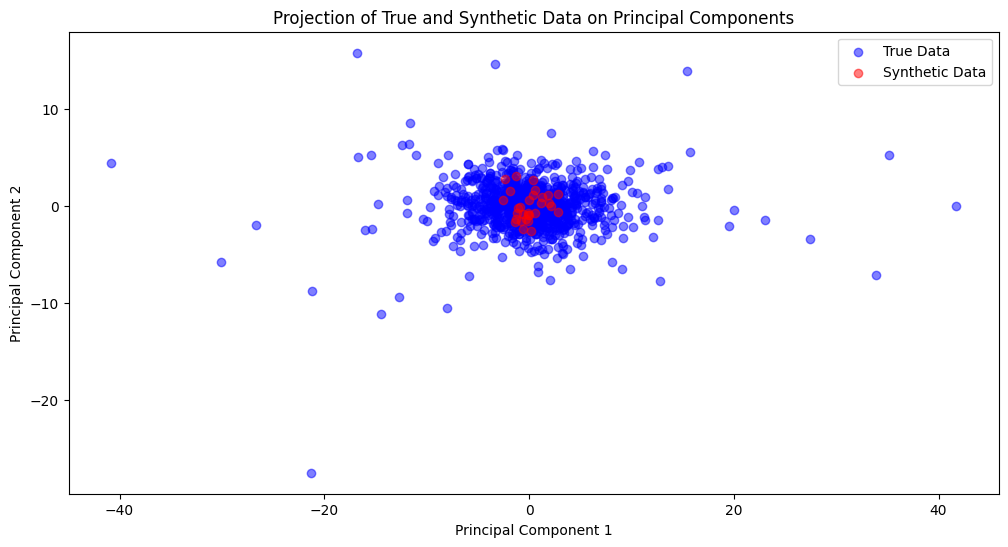

In [ ]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
